## Sample code

>> Loading a list of 2 images
 - adding dust3r/croco/assets/Chateau1.png with resolution 224x224 --> 512x384
 - adding dust3r/croco/assets/Chateau2.png with resolution 224x224 --> 512x384
 (Found 2 images)
torch.Size([1, 384, 512, 3])
torch.Size([1, 384, 512, 3])
dict_keys(['img', 'true_shape', 'idx', 'instance'])
torch.Size([1, 3, 384, 512])


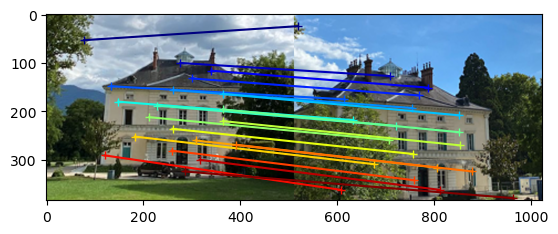

In [6]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

if __name__ == '__main__':
    device = 'cpu'
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    images = load_images(['dust3r/croco/assets/Chateau1.png', 'dust3r/croco/assets/Chateau2.png'], size=512)
    output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']

    print(pred1['pts3d'].shape)
    print(pred2['pts3d_in_other_view'].shape)
    
    print(view1.keys())
    print(view1["img"].shape)
    desc1, desc2 = pred1['desc'].squeeze(0).detach(), pred2['desc'].squeeze(0).detach()

    # find 2D-2D matches between the two images
    matches_im0, matches_im1 = fast_reciprocal_NNs(desc1, desc2, subsample_or_initxy1=8,
                                                   device=device, dist='dot', block_size=2**13)

    # ignore small border around the edge
    H0, W0 = view1['true_shape'][0]
    valid_matches_im0 = (matches_im0[:, 0] >= 3) & (matches_im0[:, 0] < int(W0) - 3) & (
        matches_im0[:, 1] >= 3) & (matches_im0[:, 1] < int(H0) - 3)

    H1, W1 = view2['true_shape'][0]
    valid_matches_im1 = (matches_im1[:, 0] >= 3) & (matches_im1[:, 0] < int(W1) - 3) & (
        matches_im1[:, 1] >= 3) & (matches_im1[:, 1] < int(H1) - 3)

    valid_matches = valid_matches_im0 & valid_matches_im1
    matches_im0, matches_im1 = matches_im0[valid_matches], matches_im1[valid_matches]

    # visualize a few matches
    import numpy as np
    import torch
    import torchvision.transforms.functional
    from matplotlib import pyplot as pl

    n_viz = 20
    num_matches = matches_im0.shape[0]
    match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
    viz_matches_im0, viz_matches_im1 = matches_im0[match_idx_to_viz], matches_im1[match_idx_to_viz]

    image_mean = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)
    image_std = torch.as_tensor([0.5, 0.5, 0.5], device='cpu').reshape(1, 3, 1, 1)

    viz_imgs = []
    for i, view in enumerate([view1, view2]):
        rgb_tensor = view['img'] * image_std + image_mean
        viz_imgs.append(rgb_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy())

    H0, W0, H1, W1 = *viz_imgs[0].shape[:2], *viz_imgs[1].shape[:2]
    img0 = np.pad(viz_imgs[0], ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img1 = np.pad(viz_imgs[1], ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 'constant', constant_values=0)
    img = np.concatenate((img0, img1), axis=1)
    pl.figure()
    pl.imshow(img)
    cmap = pl.get_cmap('jet')
    for i in range(n_viz):
        (x0, y0), (x1, y1) = viz_matches_im0[i].T, viz_matches_im1[i].T
        pl.plot([x0, x1 + W0], [y0, y1], '-+', color=cmap(i / (n_viz - 1)), scalex=False, scaley=False)
    pl.show(block=True)

## Frame 0 - 3

In [1]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

import csv

if __name__ == '__main__':
    device = 'cpu'
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    
    for i in range(0, 3):

        images = load_images(["Frames/frame%d.jpg" % i, "Frames/frame%d.jpg" % (i+1)], size=512)
        
        output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

        # at this stage, you have the raw dust3r predictions
        view1, pred1 = output['view1'], output['pred1']
        view2, pred2 = output['view2'], output['pred2']

        output = 'office_frames/img%d.csv' % i
        
        import torch
        import pandas as pd

        # img 1
        rgb_data = view1['img']  # torch.Size([1, 3, 384, 512])
        pts3d_data = pred1['pts3d'][0]  # torch.Size([1, 384, 512, 3])
        
        rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
        pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

        rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

        rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
        pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

        combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

        combined_data_np = combined_data.numpy()

        df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

        df.to_csv(output, index=False)

        print(f"Matrix has been written to {output}")
    
        # img 2
        output = 'office_frames/img%d.csv' % (i+1)
        
        rgb_data = view2['img']  # torch.Size([1, 3, 384, 512])
        pts3d_data = pred2['pts3d_in_other_view'][0]  # torch.Size([1, 384, 512, 3])
        
        rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
        pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

        rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

        rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
        pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

        combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

        combined_data_np = combined_data.numpy()

        df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

        df.to_csv(output, index=False)

        print(f"Matrix has been written to {output}")

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead
>> Loading a list of 2 images
 - adding Frames/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding Frames/frame1.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to office_frames/img0.csv
Matrix has been written to office_frames/img1.csv
>> Loading a list of 2 images
 - adding Frames/frame1.jpg with resolution 1080x1920 --> 288x512
 - adding Frames/frame2.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to office_frames/img1.csv
Matrix has been written to office_frames/img2.csv
>> Loading a list of 2 images
 - adding Frames/frame2.jpg with resolution 1080x1920 --> 288x512
 - adding Frames/frame3.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to office_frames/img2.csv
Matrix has been written to office_frames/img3.csv


In [ ]:
import open3d as o3d
import pandas as pd
import numpy as np

draw_list = []

def foo(i):
    csv_file = 'office_frames/img%d.csv' % i  # Replace with the path to your CSV file
    df = pd.read_csv(csv_file)

    # Assuming your CSV file has columns named 'x', 'y', 'z', 'r', 'g', 'b'
    points = df[['x', 'y', 'z']].values
    colors = df[['r', 'g', 'b']].values

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)
    
    return point_cloud

point_cloud0 = foo(0)
point_cloud1 = foo(1)
point_cloud2 = foo(2)
point_cloud3 = foo(3)

# Step 3: Visualize the PointCloud
o3d.visualization.draw_geometries([point_cloud0, point_cloud1, point_cloud2, point_cloud3])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Frame 0-5

In [1]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

import csv

if __name__ == '__main__':
    device = 'cpu'
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    
    for i in range(0, 5):

        images = load_images(["Frames/frame%d.jpg" % i, "Frames/frame%d.jpg" % (i+1)], size=512)
        
        output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

        # at this stage, you have the raw dust3r predictions
        view1, pred1 = output['view1'], output['pred1']
        view2, pred2 = output['view2'], output['pred2']

        output = 'office_frames/img%d.csv' % i
        
        import torch
        import pandas as pd

        # img 1
        rgb_data = view1['img']  # torch.Size([1, 3, 384, 512])
        pts3d_data = pred1['pts3d'][0]  # torch.Size([1, 384, 512, 3])
        
        rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
        pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

        rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

        rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
        pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

        combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

        combined_data_np = combined_data.numpy()

        df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

        df.to_csv(output, index=False)

        print(f"Matrix has been written to {output}")
    
        # img 2
        output = 'office_frames/img%d.csv' % (i+1)
        
        rgb_data = view2['img']  # torch.Size([1, 3, 384, 512])
        pts3d_data = pred2['pts3d_in_other_view'][0]  # torch.Size([1, 384, 512, 3])
        
        rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
        pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

        rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

        rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
        pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

        combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

        combined_data_np = combined_data.numpy()

        df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

        df.to_csv(output, index=False)

        print(f"Matrix has been written to {output}")

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead
>> Loading a list of 2 images
 - adding Frames/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding Frames/frame1.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to office_frames/img0.csv
Matrix has been written to office_frames/img1.csv
>> Loading a list of 2 images
 - adding Frames/frame1.jpg with resolution 1080x1920 --> 288x512
 - adding Frames/frame2.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to office_frames/img1.csv
Matrix has been written to office_frames/img2.csv
>> Loading a list of 2 images
 - adding Frames/frame2.jpg with resolution 1080x1920 --> 288x512
 - adding Frames/frame3.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to office_frames/img2.csv
Matrix has been written to office_frames/img3.csv
>> Loading a list of 2 images
 - adding Frames/frame3.jpg with resolu

In [ ]:
import open3d as o3d
import pandas as pd
import numpy as np

draw_list = []

def foo(i):
    csv_file = 'office_frames/img%d.csv' % i  # Replace with the path to your CSV file
    df = pd.read_csv(csv_file)

    # Assuming your CSV file has columns named 'x', 'y', 'z', 'r', 'g', 'b'
    points = df[['x', 'y', 'z']].values
    colors = df[['r', 'g', 'b']].values

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)
    
    return point_cloud

point_cloud0 = foo(0)
point_cloud1 = foo(1)
point_cloud2 = foo(2)
point_cloud3 = foo(3)
point_cloud4 = foo(4)
point_cloud5 = foo(5)

# Step 3: Visualize the PointCloud
o3d.visualization.draw_geometries([point_cloud0, point_cloud1, point_cloud2, point_cloud3, point_cloud4, point_cloud5])


## Frame 0-16

In [1]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

import csv

if __name__ == '__main__':
    device = 'cpu'
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)

    for i in range(0, 16):

        images = load_images(["Frames_v2/frame%d.jpg" % i, "Frames_v2/frame%d.jpg" % (i+1)], size=512)
        
        output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

        # at this stage, you have the raw dust3r predictions
        view1, pred1 = output['view1'], output['pred1']
        view2, pred2 = output['view2'], output['pred2']

        output = 'office_frames_v2/img%d.csv' % i
        
        import torch
        import pandas as pd

        # img 1
        rgb_data = view1['img']  # torch.Size([1, 3, 384, 512])
        pts3d_data = pred1['pts3d'][0]  # torch.Size([1, 384, 512, 3])
        
        rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
        pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

        rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

        rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
        pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

        combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

        combined_data_np = combined_data.numpy()

        df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

        df.to_csv(output, index=False)

        print(f"Matrix has been written to {output}")
    
        # img 2
        output = 'office_frames_v2/img%d.csv' % (i+1)
        
        rgb_data = view2['img']  # torch.Size([1, 3, 384, 512])
        pts3d_data = pred2['pts3d_in_other_view'][0]  # torch.Size([1, 384, 512, 3])
        
        rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
        pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

        rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

        rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
        pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

        combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

        combined_data_np = combined_data.numpy()

        df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

        df.to_csv(output, index=False)

        print(f"Matrix has been written to {output}")

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead
>> Loading a list of 2 images
 - adding Frames_v2/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding Frames_v2/frame1.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to office_frames_v2/img0.csv
Matrix has been written to office_frames_v2/img1.csv
>> Loading a list of 2 images
 - adding Frames_v2/frame1.jpg with resolution 1080x1920 --> 288x512
 - adding Frames_v2/frame2.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to office_frames_v2/img1.csv
Matrix has been written to office_frames_v2/img2.csv
>> Loading a list of 2 images
 - adding Frames_v2/frame2.jpg with resolution 1080x1920 --> 288x512
 - adding Frames_v2/frame3.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to office_frames_v2/img2.csv
Matrix has been written to office_frames_v2/img3.csv
>> Loading a list of 2 images
 - 

In [ ]:
import open3d as o3d
import pandas as pd
import numpy as np

# Function to load a point cloud from a CSV file
def foo(i):
    csv_file = f'office_frames_v2/img{i}.csv'  # Use f-string for dynamic file name
    df = pd.read_csv(csv_file)

    # Assuming your CSV file has columns named 'x', 'y', 'z', 'r', 'g', 'b'
    points = df[['x', 'y', 'z']].values
    colors = df[['r', 'g', 'b']].values

    # Create and return a PointCloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)
    
    return point_cloud

# Step 2: Use a loop to create a list of point clouds from foo(0) to foo(16)
point_clouds = [foo(i) for i in range(17)]  # Creates a list with point clouds from foo(0) to foo(16)

# Step 3: Visualize all the point clouds together
o3d.visualization.draw_geometries(point_clouds)


## Gate video Frame 0 - 6
- 視角轉換

In [2]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

import csv

if __name__ == '__main__':
    device = 'cpu'
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    
    for i in range(1, 7):

        images = load_images(["gate_frames/frame0.jpg", "gate_frames/frame%d.jpg" % i], size=512)
        
        output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

        # at this stage, you have the raw dust3r predictions
        view1, pred1 = output['view1'], output['pred1']
        view2, pred2 = output['view2'], output['pred2']

        if i == 1:
            output = 'gate_frames_csv/img0.csv'
        
            import torch
            import pandas as pd

            # img 1
            rgb_data = view1['img']  # torch.Size([1, 3, 384, 512])
            pts3d_data = pred1['pts3d'][0]  # torch.Size([1, 384, 512, 3])

            rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
            pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

            rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

            rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
            pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

            combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

            combined_data_np = combined_data.numpy()

            df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

            df.to_csv(output, index=False)

            print(f"Matrix has been written to {output}")
    
        # img 2
        output = 'gate_frames_csv/img%d.csv' % i
        
        rgb_data = view2['img']  # torch.Size([1, 3, 384, 512])
        pts3d_data = pred2['pts3d_in_other_view'][0]  # torch.Size([1, 384, 512, 3])
        
        rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
        pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

        rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

        rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
        pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

        combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

        combined_data_np = combined_data.numpy()

        df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

        df.to_csv(output, index=False)

        print(f"Matrix has been written to {output}")

>> Loading a list of 2 images
 - adding gate_frames/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding gate_frames/frame1.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to gate_frames_csv/img0.csv
Matrix has been written to gate_frames_csv/img1.csv
>> Loading a list of 2 images
 - adding gate_frames/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding gate_frames/frame2.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to gate_frames_csv/img2.csv
>> Loading a list of 2 images
 - adding gate_frames/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding gate_frames/frame3.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to gate_frames_csv/img3.csv
>> Loading a list of 2 images
 - adding gate_frames/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding gate_frames/frame4.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to gate_

In [ ]:
import open3d as o3d
import pandas as pd
import numpy as np

# Function to load a point cloud from a CSV file
def foo(i):
    csv_file = f'gate_frames_csv/img{i}.csv'  # Use f-string for dynamic file name
    df = pd.read_csv(csv_file)

    # Assuming your CSV file has columns named 'x', 'y', 'z', 'r', 'g', 'b'
    points = df[['x', 'y', 'z']].values
    colors = df[['r', 'g', 'b']].values

    # Create and return a PointCloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)
    
    return point_cloud

# Step 2: Use a loop to create a list of point clouds from foo(0) to foo(16)
point_clouds = [foo(i) for i in range(7)]  # Creates a list with point clouds from foo(0) to foo(16)

# Step 3: Visualize all the point clouds together
o3d.visualization.draw_geometries(point_clouds)


## Gate Frame 0 - 13
- 視角轉換

In [4]:
from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import fast_reciprocal_NNs

import mast3r.utils.path_to_dust3r
from dust3r.inference import inference
from dust3r.utils.image import load_images

import torch
import pandas as pd
import csv

if __name__ == '__main__':
    device = 'cpu'
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    
    for i in range(1, 14):

        images = load_images(["gate_frames_v2/frame0.jpg", "gate_frames_v2/frame%d.jpg" % i], size=512)
        
        output = inference([tuple(images)], model, device, batch_size=1, verbose=False)

        # at this stage, you have the raw dust3r predictions
        view1, pred1 = output['view1'], output['pred1']
        view2, pred2 = output['view2'], output['pred2']

        if i == 1:
            output = 'gate_frames_csv_v2/img0.csv'

            # img 1
            rgb_data = view1['img']  # torch.Size([1, 3, 384, 512])
            pts3d_data = pred1['pts3d'][0]  # torch.Size([1, 384, 512, 3])

            rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
            pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

            rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

            rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
            pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

            combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

            combined_data_np = combined_data.numpy()

            df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

            df.to_csv(output, index=False)

            print(f"Matrix has been written to {output}")
    
        # img 2
        output = 'gate_frames_csv_v2/img%d.csv' % i
        
        rgb_data = view2['img']  # torch.Size([1, 3, 384, 512])
        pts3d_data = pred2['pts3d_in_other_view'][0]  # torch.Size([1, 384, 512, 3])
        
        rgb_data = rgb_data.squeeze(0)  # torch.Size([3, 384, 512])
        pts3d_data = pts3d_data.squeeze(0)  # torch.Size([384, 512, 3])

        rgb_data = rgb_data.permute(1, 2, 0)  # torch.Size([384, 512, 3])

        rgb_flat = rgb_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for RGB
        pts3d_flat = pts3d_data.reshape(-1, 3)  # Shape: (384 * 512, 3) for XYZ

        combined_data = torch.cat((pts3d_flat, rgb_flat), dim=1)  # Shape: (384 * 512, 6)

        combined_data_np = combined_data.numpy()

        df = pd.DataFrame(combined_data_np, columns=['x', 'y', 'z', 'r', 'g', 'b'])

        df.to_csv(output, index=False)

        print(f"Matrix has been written to {output}")

>> Loading a list of 2 images
 - adding gate_frames_v2/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding gate_frames_v2/frame1.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to gate_frames_csv_v2/img0.csv
Matrix has been written to gate_frames_csv_v2/img1.csv
>> Loading a list of 2 images
 - adding gate_frames_v2/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding gate_frames_v2/frame2.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to gate_frames_csv_v2/img2.csv
>> Loading a list of 2 images
 - adding gate_frames_v2/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding gate_frames_v2/frame3.jpg with resolution 1080x1920 --> 288x512
 (Found 2 images)
Matrix has been written to gate_frames_csv_v2/img3.csv
>> Loading a list of 2 images
 - adding gate_frames_v2/frame0.jpg with resolution 1080x1920 --> 288x512
 - adding gate_frames_v2/frame4.jpg with resolution 1080x1920 --> 288x512
 (Found 2 imag

In [ ]:
import open3d as o3d
import pandas as pd
import numpy as np

# Function to load a point cloud from a CSV file
def foo(i):
    csv_file = f'gate_frames_csv_v2/img{i}.csv'  # Use f-string for dynamic file name
    df = pd.read_csv(csv_file)

    # Assuming your CSV file has columns named 'x', 'y', 'z', 'r', 'g', 'b'
    points = df[['x', 'y', 'z']].values
    colors = df[['r', 'g', 'b']].values

    # Create and return a PointCloud object
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)
    
    return point_cloud

# Step 2: Use a loop to create a list of point clouds from foo(0) to foo(16)
point_clouds = [foo(i) for i in range(14)]  # Creates a list with point clouds from foo(0) to foo(16)

# Step 3: Visualize all the point clouds together
o3d.visualization.draw_geometries(point_clouds)
